# Bank Loan Defaulter Hackathon Project
### Submitted by Himanshu Saini
#### Dataset Link: https://www.kaggle.com/datasets/ankitkalauni/bank-loan-defaulter-prediction-hackathon

In [215]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [217]:
# Download the data
df_train = pd.read_csv("train.csv")

## Data Exploration

In [218]:
print ("First 5 rows:\n", df_train.head())

In [219]:
# Shape of the dataset
print ("Dataset shape:", df_train.shape)

In [220]:
# Display column types and null counts
print ("Column types and null counts:\n", df_train.info())

In [221]:
# Null counts
print ("Null counts:\n", df_train.isnull().sum())

In [222]:
# Data types counts grouopby columns
for dtype, cols in df_train.groupby(df_train.dtypes, axis=1):
    print(f"{dtype} ({len(cols.columns)} columns):")
    print(list(cols.columns))

In [223]:
# Summary statistics
print ("Summary statistics:\n", df_train.describe())

### Train dataset basic information
#### 1. There are 35 columns.
#### 2. 67463 entries.
#### 3. Null counts zero.
#### 4. Datatype distribution:
```
int64 (17 columns):
['ID', 'Loan Amount', 'Funded Amount', 'Term', 'Delinquency - two years', 'Inquires - six months', 'Open Account', 'Public Record', 'Revolving Balance', 'Total Accounts', 'Collection 12 months Medical', 'Last week Pay', 'Accounts Delinquent', 'Total Collection Amount', 'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status']

float64 (9 columns):
['Funded Amount Investor', 'Interest Rate', 'Home Ownership', 'Debit to Income', 'Revolving Utilities', 'Total Received Interest', 'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee']

object (9 columns):
['Batch Enrolled', 'Grade', 'Sub Grade', 'Employment Duration', 'Verification Status', 'Payment Plan', 'Loan Title', 'Initial List Status', 'Application Type']
```

In [224]:
# Identify train dataset column types.
df_train_categorical_cols = df_train.select_dtypes(include="object").columns.tolist()
df_train_numerical_cols = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [225]:
# Display unique counts for train dataset columns.
for col in df_train_numerical_cols:
    if df_train[col].nunique()<=200:
        print (col, df_train[col].nunique())

for col in df_train_categorical_cols:
    if df_train[col].nunique()<=200:
        print (col, df_train[col].nunique())

In [226]:
df_train.nunique().sort_values().plot(kind="barh", figsize=(10, 12))
plt.xscale("log")
plt.title("Unique Values per Column")
plt.axvline(x=40, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [227]:
df_train.columns

In [228]:
# Get all the categorical features out from train data.
df_train_filter = df_train.loc[:, df_train.nunique() <= 40]
df_train_filter.info()

In [229]:
df_train_numerical_cols

In [230]:
df_train.columns

In [232]:
"""
for col in df_train_numerical_cols:
    sns.boxplot(data=df_train, x="Loan Status", y=col)
    plt.title(f"{col} vs Loan Status")
    plt.show()
"""

In [233]:
# Define outlier capping function (calling and flooring).
def outlier_processing(x):
     x = x.clip(lower=x.quantile(0.05), upper=x.quantile(0.95))
     return x

In [234]:
# Apply Capping to Numeric Columns of train dataset.
#df_train[df_train_numerical_cols] = df_train[df_train_numerical_cols].apply(lambda x : outlier_processing(x))
df_train[df_train_numerical_cols] = df_train[df_train_numerical_cols].apply(outlier_processing)

In [235]:
# Describe Data After Capping
df_train[df_train_numerical_cols].describe(percentiles=[0.01,0.05,0.25,0.50,0.75,0.95,0.99])

In [236]:
# Variance of Columns
df_train[df_test_numerical_cols].var().sort_values()

In [237]:
# Define thresholds
drop_threshold = 0.0001
flag_threshold = 0.05

# Drop zero/near-zero variance columns
zero_var_cols = df_train[df_train_numerical_cols].var(numeric_only=True)
zero_var_cols = zero_var_cols[zero_var_cols < drop_threshold].index.tolist()

# Flag low-variance columns for review (but not yet dropped)
low_var_cols = df_train[df_train_numerical_cols].var(numeric_only=True)
low_var_cols = low_var_cols[(low_var_cols >= drop_threshold) & (low_var_cols < flag_threshold)].index.tolist()

print("Drop these (zero or near-zero variance):", zero_var_cols)
print("Review these (low variance):", low_var_cols)

In [238]:
# Initialize result dictionary
cat_analysis = {}

# Thresholds
dominance_threshold = 0.95
high_card_threshold = 100

# Analyze each categorical column
for col in df_train_categorical_cols:
    n_unique = df_train[col].nunique(dropna=False)
    top_freq = df_train[col].value_counts(normalize=True, dropna=False).iloc[0]
    cat_analysis[col] = {
        "Unique Values": n_unique,
        "Top Category %": round(top_freq * 100, 2),
        "Drop (High Cardinality)": n_unique > high_card_threshold,
        "Drop (Dominant Category)": top_freq > dominance_threshold
    }

# Convert to DataFrame
cat_analysis_df = pd.DataFrame(cat_analysis).T.sort_values(by="Unique Values")

In [239]:
cat_analysis_df

### From the above analysis we found the following:
### 1. Drop numerical col "Collection 12 months Medical", "Accounts Delinquent" because they have zero variance therefore, should drop.
### 2. Drop categorical col "Payment Plan", "Application Type" because constant values and highly imbalance.

In [240]:
drop_col = ['ID', 'Collection 12 months Medical', 'Accounts Delinquent', 'Payment Plan', 'Application Type']
df_train.drop(columns=drop_col, inplace=True)

In [241]:
df_train.columns

In [242]:
# Here we will analyze the categorical columns and suggest encoding methods based on their characteristics.
# Select categorical columns
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

# Prepare summary
encoding_suggestions = []

for col in cat_cols:
    unique_vals = df_train[col].nunique(dropna=False)
    top_cat_pct = df_train[col].value_counts(normalize=True, dropna=False).iloc[0] # The percentage of rows that belong to the most frequent category in a given column.

    if unique_vals <= 10:
        if col in ['Grade']:  # Known ordinal from domain
            encoding_type = "Ordinal Encoding"
        else:
            encoding_type = "One-Hot Encoding"
    elif 10 < unique_vals <= 50:
        encoding_type = "Label Encoding"
    elif unique_vals > 50:
        encoding_type = "Frequency Encoding / Target Encoding"
    else:
        encoding_type = "Review Manually"

    dominance_flag = "Dominant Category" if top_cat_pct > 0.95 else ""
    
    encoding_suggestions.append({
        "Column": col,
        "Unique Values": unique_vals,
        "Top Category %": round(top_cat_pct * 100, 2),
        "Suggested Encoding": encoding_type,
        "Note": dominance_flag
    })

# Convert to DataFrame
encoding_df = pd.DataFrame(encoding_suggestions).sort_values(by="Unique Values")

In [243]:
encoding_df

In [244]:
# Implemnting encoding

from sklearn.preprocessing import LabelEncoder

# --- 1. Ordinal Encoding for 'Grade'
grade_order = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
df_train["Grade"] = df_train["Grade"].map(grade_order)

# --- 2. Label Encoding for 'Sub Grade' and 'Batch Enrolled'
label_cols = ["Sub Grade", "Batch Enrolled"]
le = LabelEncoder()
for col in label_cols:
    df_train[col] = le.fit_transform(df_train[col])

# --- 3. Frequency Encoding for 'Loan Title'
freq_map = df_train["Loan Title"].value_counts().to_dict()
df_train["Loan Title"] = df_train["Loan Title"].map(freq_map)

# --- 4. One-Hot Encoding for 'Initial List Status', 'Employment Duration', 'Verification Status'
one_hot_cols = ["Initial List Status", "Employment Duration", "Verification Status"]
df_train_encoded = pd.get_dummies(df_train, columns=one_hot_cols, drop_first=True)

In [245]:
df_train_encoded.head()

In [246]:
df_train_encoded.columns

In [247]:
print ("Loan Status" in df_train_encoded.columns)

### Feature Engineering.

In [248]:
# --- 1. Imports ---
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [249]:
# --- 2. Split the train and test datasets ---
from sklearn.model_selection import train_test_split

X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [250]:
X_train.info()

In [251]:
# --- 3. Check the class distribution ---
print("Original Class Distribution:")
print(Counter(y_train))

In [252]:
# --- 3. Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Distribution after SMOTE:")  
print(Counter(y_train_smote))

In [253]:
# --- 4. Apply NearMiss ---
nearmiss = NearMiss(version=1)
X_train_nm, y_train_nm = nearmiss.fit_resample(X_train, y_train)
print("Distribution after NearMiss:")
print(Counter(y_train_nm))

In [254]:
# --- 5. Compare in Table ---
comparison_df = pd.DataFrame({
    "Original": pd.Series(Counter(y_train)),
    "SMOTE": pd.Series(Counter(y_train_smote)),
    "NearMiss": pd.Series(Counter(y_train_nm))
}).T
comparison_df.columns = ["Non-Defaulter (0)", "Defaulter (1)"]
print("Class Distribution Comparison:")
display(comparison_df)

In [255]:
# --- 6. Plotting ---
comparison_df.plot(kind="bar", figsize=(8, 4), colormap="viridis")
plt.title("Class Distribution: Original vs SMOTE vs NearMiss")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Machine Learning Modeling

## 1. Logistic Regression

In [304]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics (for classification)
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve

# Model Selection (Optional for tuning)
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold


In [277]:
def evaluateModel(model, X_train, y_train, X_test, y_test, name="", refit=True, positive_label=1):
    # Fit only if requested
    if refit:
        model.fit(X_train, y_train)

    # Get probabilities with the correct column for the positive class (I made a mistake here before.)
    y_prob = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        # Find the column index for the desired positive_label
        pos_idx = np.where(model.classes_ == positive_label)[0][0]
        y_prob = proba[:, pos_idx]

    # Use sklearn's predict (which applies its own threshold consistently)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    con_mat = confusion_matrix(y_test, y_pred)

    # Feature importance / coefficients
    feature_importance = None
    if hasattr(model, "feature_importances_"):
        feature_importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        try:
            feature_importance = np.abs(model.coef_[0])
        except Exception:
            feature_importance = None

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Confusion Matrix": con_mat,
        "Feature Importance": feature_importance,
        "y_pred": y_pred,      # include these for debugging/plots
        "y_prob": y_prob,
        # For debugging
        "classes_": getattr(model, "classes_", None),
        "positive_label": positive_label,
        "positive predicted": (y_pred == positive_label).sum()
    }

In [272]:
y_test

In [ ]:
# Create model
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Evaluate on original data
result_lr_orig = evaluateModel(lr, X_train, y_train, X_test, y_test, name="LogReg - Original")

# Evaluate on SMOTE-balanced data
result_lr_smote = evaluateModel(lr, X_train_smote, y_train_smote, X_test, y_test, name="LogReg - SMOTE")

# Evaluate on NearMiss-balanced data
result_lr_nm = evaluateModel(lr, X_train_nm, y_train_nm, X_test, y_test, name="LogReg - NearMiss")

In [274]:
result_lr_orig

In [275]:
result_lr_smote

In [276]:
result_lr_nm

## Logistic Regression Model Evaluation

| Resampling Strategy | Accuracy | Precision | Recall | F1 Score | ROC AUC | Comments                                                                            | Best Use Case                                                                                                         |
| ------------------- | -------- | --------- | ------ | -------- | ------- | ----------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **Original**        | 0.5470   | 0.0984    | 0.4775 | 0.1632   | 0.5157  | Moderate recall with low precision; class imbalance still impacts performance, leading to many false positives and a low ROC AUC. | When you need a quick baseline and want moderate recall without complex preprocessing.                                |
| **SMOTE**           | 0.5399   | 0.0984    | 0.4671 | 0.1581   | 0.5102  | Similar to original; oversampling improves class balance but doesn't significantly boost performance—model likely limited by feature separability. | Balanced datasets where you expect model behavior similar to original but want to avoid bias toward majority class.   |
| **NearMiss**        | 0.3406   | 0.0948    | 0.7171 | 0.1674   | 0.5082  | Significantly increases recall (captures more positives) but at the cost of accuracy and precision; high false positive rate due to aggressive undersampling. | Situations where missing a positive case is more costly than false alarms (e.g., fraud detection, medical screening). |


## 2. Decision Tree Classifier

In [278]:
# Base model setup
dt = DecisionTreeClassifier(
                            random_state=42,
                            class_weight='balanced',
                            max_depth=8, # Adjust max_depth as needed (6-12 is a good range to start with, but you can tune it further if needed.
                            min_samples_leaf=30,
                            min_samples_split=50,
                            max_features='sqrt',  # Use square root of features for splits
                            )

# Original
result_dt_orig = evaluateModel(dt, X_train, y_train, X_test, y_test, name="DecisionTree - Original")

# SMOTE
result_dt_smote = evaluateModel(dt, X_train_smote, y_train_smote, X_test, y_test, name="DecisionTree - SMOTE")

# NearMiss
result_dt_nm = evaluateModel(dt, X_train_nm, y_train_nm, X_test, y_test, name="DecisionTree - NearMiss")

In [279]:
result_dt_orig

In [280]:
result_dt_smote

In [281]:
result_dt_nm

## Decision Tree Classifier Model Evaluation

| Resampling Strategy | Accuracy | Precision | Recall | F1 Score | ROC AUC | Comments                                                                                  | Best Use Case                                                             |
| ------------------- | -------- | --------- | ------ | -------- | ------- | ----------------------------------------------------------------------------------------- | ------------------------------------------------------------------------- |
| **Original**        | 0.5312   | 0.0934    | 0.4671 | 0.1557   | 0.5073  | Low precision and ROC AUC; tree overfitting likely; predicts many positives incorrectly.  | Balanced baseline; quick reference before resampling.                     |
| **SMOTE**           | 0.6662   | 0.0914    | 0.2917 | 0.1391   | 0.4883  | Better accuracy from balancing classes, but recall dropped sharply; still poor precision. | When higher accuracy is more important than catching all positives.       |
| **NearMiss**        | 0.3623   | 0.0934    | 0.6771 | 0.1642   | 0.5026  | High recall but accuracy suffers; many false positives due to aggressive undersampling.   | When maximizing recall is the top priority (e.g., catching all defaults). |


## 3. Random Forest Classifier

In [282]:
# Initialize with base settings
rf = RandomForestClassifier(
                            random_state=42,
                            class_weight='balanced',
                            n_estimators=300,  # Number of trees in the forest
                            max_depth=8,      # Maximum depth of each tree
                            min_samples_leaf=30,  # Minimum samples required to be at a leaf node
                            min_samples_split=50,  # Minimum samples required to split an internal node
                            max_features='sqrt'  # Use square root of features for splits
                            )

In [283]:
# Original
result_rf_orig = evaluateModel(rf, X_train, y_train, X_test, y_test, name="RandomForest - Original")

# SMOTE
result_rf_smote = evaluateModel(rf, X_train_smote, y_train_smote, X_test, y_test, name="RandomForest - SMOTE")

# NearMiss
result_rf_nm = evaluateModel(rf, X_train_nm, y_train_nm, X_test, y_test, name="RandomForest - NearMiss")

In [284]:
result_rf_orig

In [285]:
result_rf_smote

In [286]:
result_rf_nm

## Random Forest Classifier Model Evaluation

| Resampling Strategy | Accuracy | Precision | Recall | F1 Score | ROC AUC | Comments                                                                                                                |
| ------------------- | -------- | --------- | ------ | -------- | ------- | ----------------------------------------------------------------------------------------------------------------------- |
| **Original**        | 0.7927   | 0.1114    | 0.1779 | 0.1370   | 0.5376  | Good overall accuracy, but still weak recall for minority class — many positives missed despite balanced class weights. |
| **SMOTE**           | 0.7972   | 0.0926    | 0.1354 | 0.1100   | 0.4941  | Accuracy stays high, but SMOTE doesn’t improve recall here; possible overfitting to synthetic patterns.                 |
| **NearMiss**        | 0.3035   | 0.0932    | 0.7484 | 0.1658   | 0.5053  | Very high recall (good at finding positives) but massive accuracy drop due to many false positives.                     |

## 4. Support Vector Classifier (SVC)

In [287]:
# Initialize with probability enabled for ROC AUC
svc = SVC(
            random_state=42,
            probability=True,
            class_weight='balanced',  # Use balanced class weights
            kernel='rbf',  # Radial basis function kernel
            C=1.0,  # Regularization parameter
            gamma='scale'  # Kernel coefficient (1 / (n_features * X.var())) if 'scale' else 'auto'  # Use 'scale' for automatic scaling based on data
            )

In [288]:
# Original
result_svc_orig = evaluateModel(svc, X_train, y_train, X_test, y_test, name="SVC - Original")

# SMOTE
result_svc_smote = evaluateModel(svc, X_train_smote, y_train_smote, X_test, y_test, name="SVC - SMOTE")

# NearMiss
result_svc_nm = evaluateModel(svc, X_train_nm, y_train_nm, X_test, y_test, name="SVC - NearMiss (Kaggle)")

In [289]:
result_svc_orig

In [290]:
result_svc_smote

In [291]:
result_svc_nm

## Support Vector Classifier Model Evaluation

| Resampling Strategy | Accuracy | Precision | Recall | F1 Score | ROC AUC | Comments                                                                                                                                      | Best Use Case                                                                                                                  |
| ------------------- | -------- | --------- | ------ | -------- | ------- | --------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **Original**        | 0.5966   | 0.0993    | 0.4167 | 0.1604   | 0.5185  | Balanced performance with slightly higher recall than precision; accuracy better than Logistic Regression & Decision Tree in Original setting | Works well for smaller to medium datasets with clear margins between classes; can capture non-linear relationships via kernels |
| **SMOTE**           | 0.4736   | 0.0953    | 0.5521 | 0.1625   | 0.5129  | Significant drop in accuracy; recall improves but precision stays low, indicating many false positives                                        | Suitable for imbalanced datasets when the minority class needs better recall, though accuracy may drop                         |
| **NearMiss**        | 0.3420   | 0.0920    | 0.6891 | 0.1623   | 0.4977  | Recall is highest among SVC runs, but accuracy is very low; model overpredicts positives                                                      | Can be used when recall is the main priority at the expense of accuracy, especially in cost-sensitive scenarios                |


## 5. XGBoost

In [297]:
np.divide(np.sum(y_train == 0), np.sum(y_train == 1))

In [299]:
# Initialize XGBoost
xgb = XGBClassifier(
                    random_state = 42,
                    n_estimators=300,               # Number of boosting rounds
                    learning_rate=0.05,             # Step size shrinkage
                    max_depth=6,                    # Depth of each tree
                    subsample=0.8,                  # Sample ratio for each tree
                    colsample_bytree=0.8,           # Features ratio per tree
                    reg_alpha=0.1,                  # L1 regularization
                    reg_lambda=1,                   # L2 regularization
                    scale_pos_weight=np.divide(np.sum(y_train == 0), np.sum(y_train == 1)),    # Adjust based on class imbalance
                    use_label_encoder=False,        # Avoid warning for label encoder
                    eval_metric="auc",              # Track AUC during training
                    tree_method='hist',             # Faster training
                    gamma=1,                        # Minimum loss reduction required to make a further partition on a leaf node 
                    )

In [300]:
# Evaluate on Original Data
result_xgb_orig = evaluateModel(xgb, X_train, y_train, X_test, y_test, name="XGBoost - Original")

# Evaluate on SMOTE-balanced Data
result_xgb_smote = evaluateModel(xgb, X_train_smote, y_train_smote, X_test, y_test, name="XGBoost - SMOTE")

# Evaluate on NearMiss-balanced Data
result_xgb_nm = evaluateModel(xgb, X_train_nm, y_train_nm, X_test, y_test, name="XGBoost - NearMiss")


In [301]:
result_xgb_orig

In [302]:
result_xgb_smote

In [303]:
result_xgb_nm

## XGBoost Model Evaluation

| Model Variant                                | Accuracy | Precision | Recall | F1 Score | ROC AUC | Comment                                                                                                                                                                                | Best Use Case                                                                                                                    |
| -------------------------------------------- | -------- | --------- | ------ | -------- | ------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| XGBoost – Original (with `scale_pos_weight`) | 0.7906   | 0.0916    | 0.1418 | 0.1113   | 0.5070  | Balanced class weight helped avoid predicting all negatives (unlike before), but recall is still low. Needs tuning of tree depth, learning rate, and regularization for better recall. | Suitable for structured/tabular data when explainability and feature importance are important, and imbalance handling is needed. |
| XGBoost – SMOTE                              | 0.4439   | 0.0922    | 0.5665 | 0.1586   | 0.5012  | Recall improved significantly, but accuracy dropped sharply — typical with oversampling for imbalanced data. Still suffers from low precision, indicating many false positives.        | Useful when high recall is crucial (e.g., fraud detection, risk flagging) and you can tolerate false positives.                  |
| XGBoost – NearMiss                           | 0.1507   | 0.0929    | 0.9335 | 0.1690   | 0.5064  | Extreme class balancing led to very high recall but almost unusable accuracy — predicts most cases as positive. Only viable if missing a positive is extremely costly.                 | Best when false negatives are unacceptable (e.g., safety-critical anomaly detection) and you can afford high false positives.    |

# Hyperparameter Tuning

## 1. GridSearchCV

In [305]:
# Class imbalance ratio.
pos_weight = np.divide(np.sum(y_train == 0), np.sum(y_train == 1))
pos_weight

In [306]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "roc_auc"

In [307]:
# XGBoost base model for tuning
xgb = XGBClassifier(
                    random_state = 42,
                    tree_method='hist',
                    eval_metric="auc",
                    n_jobs=-1
)

In [310]:
# GridSearchCV parameters
xgb_grid = {
            "max_depth": [4, 6, 8],
            "learning_rate": [0.03, 0.1],
            "n_estimators": [300, 600],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "min_child_weight": [1, 3],
            "gamma": [0, 1],
            "scale_pos_weight": [pos_weight]
}

In [308]:
# LightGBM base model for tuning
lgbm = LGBMClassifier(
                    random_state = 42,
                    n_jobs=-1
)

In [311]:
# GridSearchCV parameters
lgbm_grid = {
            "max_depth": [-1, 6, 8],
            "learning_rate": [0.03, 0.1],
            "n_estimators": [300, 600],
            "num_leaves": [31, 63, 127],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "reg_alpha": [0.0, 0.1],
            "reg_lambda": [0.0, 1.0],
            "scale_pos_weight": [pos_weight]   # LightGBM supports this too
}

In [314]:
# CatBoost base model for tuning
cat = CatBoostClassifier(
                    random_state = 42,
                    verbose=False,
                    eval_metric="AUC",
                    loss_function='Logloss'
)

In [312]:
# GridSearchCV parameters
cat_grid = {
            "depth": [6, 8, 10],
            "learning_rate": [0.03, 0.1],
            "iterations": [300, 600],
            "l2_leaf_reg": [1, 3, 5],
            "subsample": [0.8, 1.0],
            "class_weights": [[1.0, pos_weight]]  # [weight_for_class_0, weight_for_class_1]
}

In [313]:
# Function to run GridSearchCV
def run_grid(estimator, param_grid, name):
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True,     # refit best model on full training set
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f"\n{name} — best AUC: {grid.best_score_:.4f}")
    print("Best params:", grid.best_params_)
    best_model = grid.best_estimator_
    return name, best_model, grid.best_params_, grid.best_score_

In [315]:
results = []
for name, est, grid in [
    ("XGBoost (Grid)", xgb, xgb_grid),
    ("LightGBM (Grid)", lgbm, lgbm_grid),
    ("CatBoost (Grid)", cat, cat_grid),
]:
    results.append(run_grid(est, grid, name))

In [316]:
results

In [317]:
# Evaluate best models on your held-out validation set
rows = []
for name, best_model, best_params, cv_auc in results:
    out = evaluateModel(best_model, X_train, y_train, X_test, y_test, name=name, refit=False, positive_label=1)
    rows.append({
        "Model": name,
        "Val Accuracy": out["Accuracy"],
        "Val Precision": out["Precision"],
        "Val Recall": out["Recall"],
        "Val F1": out["F1 Score"],
        "Val ROC AUC": out["ROC AUC"],
        "CV ROC AUC (best)": cv_auc,
        "Best Params": best_params
    })

In [318]:
grid_report = pd.DataFrame(rows).sort_values("Val ROC AUC", ascending=False)
grid_report

### Hyperparameter fine-tuning with RandomForest Classifier.

In [319]:
# Search around the current settings defined in RandomForestClassifier model `rf`
param_grid = {
    'n_estimators': [300, 500, 800],              # try a bit larger forests
    'max_depth': [8, 10, None],                   # keep shallow vs deep
    'min_samples_leaf': [20, 30, 50],             # slightly smaller/larger leaves
    'min_samples_split': [30, 50, 70],            # slightly smaller/larger splits
    'max_features': ['sqrt', 0.5, None],          # vary feature sampling
    'criterion': ['gini', 'log_loss']             # try log_loss for prob calibration
}

In [320]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [321]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_log_loss',  # optimizing for better probability quality
    n_jobs=-1,
    cv=cv,
    verbose=2
)

In [322]:
grid_search.fit(X_train, y_train)

In [324]:
grid_search.best_params_

In [325]:
grid_search.best_score_

### 1. Rebulid the RF Classifier with the optimized parameters from GridSeacrCV

In [327]:
best_params = {
                'criterion': 'log_loss',
                'max_depth': None,
                'max_features': None,
                'min_samples_leaf': 20,
                'min_samples_split': 30,
                'n_estimators': 800
            }

In [328]:
best_rf = RandomForestClassifier(
                                    random_state=42,
                                    class_weight='balanced',
                                    n_jobs=-1,
                                    bootstrap=True,
                                    **best_params
                                )

In [329]:
best_rf.fit(X_train, y_train)

### 2. Evaluate the model.

In [330]:
result_best_rf = evaluateModel(best_rf, X_train, y_train, X_test, y_test, name="RandomForest (Grid - neg_log_loss)", refit=False, positive_label=1)

In [331]:
result_best_rf

In [333]:
y_prob = result_best_rf["y_prob"]           # probs for class 1 from evaluate_model
prec, rec, thr = precision_recall_curve(y_test, y_prob)

# Best-F1 threshold
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx]
print("Best-F1 threshold:", best_thr, "F1:", f1[best_idx])

In [334]:
# Apply custom threshold
y_pred_opt = (y_prob >= best_thr).astype(int)

In [335]:
opt_metrics = {
    "Accuracy": (y_pred_opt == y_test).mean(),
    "Precision": precision_score(y_test, y_pred_opt, zero_division=0),
    "Recall": recall_score(y_test, y_pred_opt, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_opt, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, y_prob),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_opt)
}

In [336]:
opt_metrics

In [337]:
from sklearn.calibration import CalibratedClassifierCV

cal_rf = CalibratedClassifierCV(best_rf, method="isotonic", cv=5)
cal_rf.fit(X_train, y_train)

res_rf_cal = evaluateModel(
    cal_rf, X_train, y_train, X_test, y_test,
    name="RandomForest (Calibrated - neg_log_loss)",
    refit=False, positive_label=1
)
res_rf_cal

In [155]:
%matplotlib

In [216]:
model_metrices = pd.DataFrame([result_lr_orig, result_lr_smote, result_lr_nm, result_dt_orig, result_dt_smote, result_dt_nm, result_rf_orig, result_rf_smote, result_rf_nm, result_svc_orig, result_svc_smote, result_svc_nm, result_xgb_orig, result_xgb_smote, result_xgb_nm])

In [217]:
model_metrices

## Accuracy in Classification Models

**Accuracy** is a commonly used evaluation metric in classification tasks. It measures the **proportion of correct predictions** (both true positives and true negatives) over the **total number of predictions**.

### Formula

\[
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\]

Where:
- **TP**: True Positives – Model correctly predicts class 1
- **TN**: True Negatives – Model correctly predicts class 0
- **FP**: False Positives – Model incorrectly predicts class 1
- **FN**: False Negatives – Model incorrectly predicts class 0

---

### Example

Imagine a binary classification task with the following confusion matrix:

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| **Actual 0**  |     90      |      10     |
| **Actual 1**  |     30      |      70     |

In this case:
- TP = 70
- TN = 90
- FP = 10
- FN = 30

So,

\[
\text{Accuracy} = \frac{70 + 90}{70 + 90 + 10 + 30} = \frac{160}{200} = 0.80
\]

The model has an **accuracy of 80%**.

---

### When Accuracy Can Be Misleading

Accuracy can be **misleading when classes are imbalanced**.

Example: If 95% of samples are class 0, a model that always predicts class 0 will have 95% accuracy – but **zero recall and precision for class 1** (the minority class). Hence, **other metrics like F1 Score or ROC AUC** are preferred in such cases.

---

### Use Accuracy When:
- Classes are balanced
- Both false positives and false negatives carry equal cost


In [323]:
# PLot the Accuracies of the different models
# Sort models by Accuracy for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="Accuracy", ascending=True)["Model"], model_metrices.sort_values(by="Accuracy", ascending=True)["Accuracy"], color="dimgray")
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison (Kaggle Test Set)")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

## Precision in Classification Models

**Precision** is a metric that tells us **how many of the predicted positive instances were actually positive**. It answers the question:

> _"When the model predicts positive (class = 1), how often is it correct?"_

---

### Formula

\[
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\]

Where:
- **TP (True Positives)**: Model correctly predicts class 1
- **FP (False Positives)**: Model incorrectly predicts class 1 when it's actually 0

---

### Example

Imagine this confusion matrix for a binary classifier:

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| **Actual 0**  |     85      |      15     |
| **Actual 1**  |     30      |      70     |

- **TP = 70** (actual 1, predicted 1)
- **FP = 15** (actual 0, predicted 1)

\[
\text{Precision} = \frac{70}{70 + 15} = \frac{70}{85} \approx 0.82
\]

The precision is **82%**, meaning 82% of all predictions for the positive class were correct.

---

### When to Focus on Precision

Use **Precision** when:
- **False positives are costly** (e.g., in spam detection, a non-spam email predicted as spam is annoying).
- You want to **minimize false alarms**.

### NOTE

High precision doesn't mean high recall. You can have **high precision but low recall** if the model is very selective in predicting positives.

---

### Use Precision When:
- You want **fewer false positives**
- Examples: Spam filters, medical tests for rare diseases, fraud detection


In [219]:
# PLot the Precision of the different models
# Sort models by Accuracy for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="Precision", ascending=True)["Model"], model_metrices.sort_values(by="Precision", ascending=True)["Precision"], color="dimgray")
plt.xlabel("Precision")
plt.title("Model Precision Comparison (Kaggle Test Set)")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

## Recall in Classification Models

**Recall** (also known as **Sensitivity** or **True Positive Rate**) measures the ability of a model to identify **all relevant instances** of a class.

It answers the question:

> _"Of all the actual positives, how many did the model correctly identify?"_

---

### Formula

\[
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\]

Where:
- **TP (True Positives)**: Correctly predicted positive cases
- **FN (False Negatives)**: Actual positives incorrectly predicted as negatives

---

### Example

Using the following confusion matrix:

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| **Actual 0**  |     85      |      15     |
| **Actual 1**  |     30      |      70     |

- **TP = 70**  
- **FN = 30**

\[
\text{Recall} = \frac{70}{70 + 30} = \frac{70}{100} = 0.70
\]

So the recall is **70%**, meaning the model identified 70% of all actual positive cases.

---

### When to Focus on Recall

Use **Recall** when:
- **False negatives are costly**  
- You're okay with capturing more false positives, but want to **avoid missing any actual positives**

### Tip

You can have **high recall but low precision** if the model predicts too many positives (including wrong ones).

---

### Use Recall When:
- You want **fewer false negatives**
- Examples: Cancer detection, fraud detection, system alarms


In [220]:
# PLot the Recall of the different models
# Sort models by Recall for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="Recall", ascending=True)["Model"], model_metrices.sort_values(by="Recall", ascending=True)["Recall"], color="dimgray")
plt.xlabel("Recall")
plt.title("Model Recall Comparison (Kaggle Test Set)")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

## F1 Score in Classification Models

**F1 Score** is the **harmonic mean** of **Precision** and **Recall**, offering a balanced metric when you want to consider both false positives and false negatives.

It is particularly useful in **imbalanced classification problems**, where one class occurs more frequently than the other.

---

### Formula

\[
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\]

---

### Example

Let’s say your model has:
- **Precision = 0.82**
- **Recall = 0.70**

\[
\text{F1 Score} = 2 \times \frac{0.82 \times 0.70}{0.82 + 0.70} = 2 \times \frac{0.574}{1.52} \approx 0.755
\]

So the **F1 Score is 0.755**, representing a trade-off between precision and recall.

---

### Why Harmonic Mean?

The harmonic mean punishes extreme values more than the arithmetic mean. For example:
- If precision is 1.0 but recall is 0.0 → F1 = 0.0
- If precision and recall are both 0.5 → F1 = 0.5

Thus, F1 is high **only when both precision and recall are reasonably high**.

---

### Use F1 Score When:
- You want a **balance between precision and recall**
- The **class distribution is imbalanced**
- Examples: Fraud detection, medical diagnosis, anomaly detection

---

### F1 Score vs Accuracy

In imbalanced datasets, **accuracy may be misleading**, while **F1 Score gives better insight** into model performance on the minority class.


In [221]:
# PLot the F1 Score of the different models
# Sort models by Recall for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="F1 Score", ascending=True)["Model"], model_metrices.sort_values(by="F1 Score", ascending=True)["F1 Score"], color="dimgray")
plt.xlabel("F1 Score")
plt.title("Model F1 Score Comparison (Kaggle Test Set)")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

## ROC AUC Score (Receiver Operating Characteristic – Area Under Curve)

**ROC AUC** is a powerful metric that evaluates how well a binary classification model distinguishes between two classes.

- **ROC Curve** plots the **True Positive Rate (Recall)** against the **False Positive Rate** at various threshold settings.
- **AUC (Area Under the Curve)** summarizes the curve into a single number between **0 and 1**.

---

### Formula (Conceptual)

- **True Positive Rate (TPR)** = Recall = TP / (TP + FN)
- **False Positive Rate (FPR)** = FP / (FP + TN)

The **ROC curve** is plotted by:
- Varying the decision threshold (e.g., from 0.0 to 1.0)
- Calculating TPR and FPR for each threshold

\[
\text{AUC} = \int_0^1 TPR(FPR^{-1}(x)) \, dx
\]

This integral represents the **probability that a randomly chosen positive example ranks higher than a randomly chosen negative one**.

---

### Example (Interpretation)

| AUC Score | Interpretation               |
|-----------|-------------------------------|
| 0.5       | No discrimination (random)    |
| 0.6–0.7   | Poor                          |
| 0.7–0.8   | Fair                          |
| 0.8–0.9   | Good                          |
| 0.9–1.0   | Excellent                     |

- A model with **AUC = 0.85** is likely to rank a positive instance higher than a negative instance **85% of the time**.

---

### Use ROC AUC When:
- You want to **evaluate classification performance across all thresholds**
- You are dealing with **imbalanced data**
- You want to **compare multiple models objectively**

---

### Caution
- ROC AUC assumes ranking ability — it doesn’t tell you where your decision threshold should be.
- In extremely imbalanced datasets, **Precision-Recall AUC** may be more informative.

---

### Visualization Tip
A perfect model has an AUC of **1.0** with the curve passing through the **top-left corner** (TPR = 1, FPR = 0).


In [222]:
# PLot the ROC AUC of the different models
# Sort models by Recall for better visualization

plt.figure(figsize=(10, 6))
bars = plt.barh(model_metrices.sort_values(by="ROC AUC", ascending=True)["Model"], model_metrices.sort_values(by="ROC AUC", ascending=True)["ROC AUC"], color="dimgray")
plt.xlabel("ROC AUC")
plt.title("Model ROC AUC Comparison (Kaggle Test Set)")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

## Why Plot Feature Importance?

Feature importance helps to:
1. **Understand model behavior** – See which variables the model relies on most.
2. **Interpretability** – Gain trust in the model by identifying key decision drivers.
3. **Feature selection** – Reduce dimensionality by eliminating less important features.
4. **Improve performance** – Remove noisy or irrelevant features to improve generalization.
5. **Communicate results** – Visuals of top features help stakeholders make data-driven decisions.

---

### How It Works

For models like:
- **Decision Trees, Random Forest, XGBoost**: Importance is based on how much a feature decreases impurity (e.g., Gini, Entropy).
- **Linear Models**: Coefficients represent weights (magnitude matters, but scale needs normalization).
- **SHAP/Permutation**: Model-agnostic approaches that evaluate feature impact more robustly.

---

### Example Insight

> If **"Interest Rate"** and **"Loan Amount"** are top features in predicting default, the bank can revise loan approval criteria or interest policies accordingly.

---

### Best Practice

After training your model (especially tree-based):
- Use `.feature_importances_` (Random Forest, XGBoost)
- Sort and plot top N features
- Optionally use SHAP for deeper interpretability


## Feature Importance Analysis

We compare the top 10 most important features across the following models:
- Random Forest (Original)
- Random Forest (SMOTE)
- Random Forest (NearMiss)
- SVC (using permutation importance or SHAP)
- Decision Tree (for comparison)

This helps us assess which features are consistently influential and whether resampling changes feature reliance.

## Feature Importance: Random Forest (Original)

Understanding which features influence model predictions is essential, especially when using tree-based algorithms like Random Forest. 

We use `.feature_importances_` to extract the importance score of each feature. These scores are derived from the **average reduction in impurity** (e.g., Gini) contributed by each feature across all trees in the forest.

Below, we plot the **Top 10 most important features** from the **Random Forest model trained on the original data** (before SMOTE or NearMiss).

This helps us:
- Interpret model behavior
- Identify key drivers of loan default
- Prepare for further feature selection and comparison

We’ll later compare this with feature importance plots from SMOTE and NearMiss models.


In [223]:
# === Step 1: Filter tree-based models with valid feature importance ===
tree_models = model_metrices[model_metrices["Feature Importance"].notnull()].copy()

# === Step 2: Plot each model's top N important features ===
N = 10  # Top N features to display (change if needed)
feature_names = X_full.columns  # Ensure you're using correct feature list

for idx, row in tree_models.iterrows():
    importances = np.array(row["Feature Importance"])
    
    # Get indices of top N features
    top_idx = np.argsort(importances)[-N:][::-1]
    top_features = feature_names[top_idx]
    top_importances = importances[top_idx]
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.barh(top_features[::-1], top_importances[::-1])  # Reversed for descending bars
    plt.title(f"Feature Importance: {row['Model']}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

## Hyperparameter Tuning: Support Vector Classifier (SVC) with SMOTE

To improve the performance of our best-performing model (SVC with SMOTE), we use **GridSearchCV** to find the optimal combination of hyperparameters.

### Why Tune?
SVC is sensitive to hyperparameters such as:
- `C`: Regularization strength
- `kernel`: Linear vs. nonlinear boundaries (e.g., 'linear', 'rbf')
- `gamma`: Controls influence of points (for 'rbf' kernel)

### Steps
1. **Define Parameter Grid** for exploration.
2. **Fit GridSearchCV** on resampled training data.
3. **Evaluate** on the Kaggle-style test set.

---

In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [225]:
# Define pipeline: SMOTE + SVC
svc_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("svc", SVC(probability=True, random_state=42))
])

In [226]:
# Define param grid
param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"]
}

In [227]:
X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]

In [228]:
# Grid Search
grid_svc = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring="f1", verbose=1, n_jobs=-1)
grid_svc.fit(X, y)  # X and y = original train set

In [235]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

# Step 1: Subsample for tuning (10K examples, stratified)
sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
for small_idx, _ in sss.split(X, y):
    X_small, y_small = X.iloc[small_idx], y.iloc[small_idx]

# Step 2: Define pipeline
svc_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("svc", SVC(probability=True, random_state=42))
])

# Step 3: Refined param grid (only 4 fits now)
param_grid = {
    "svc__C": [1, 10],
    "svc__kernel": ["rbf"],
    "svc__gamma": ["scale"]
}

# Step 4: Grid Search (CV=3)
grid_svc = GridSearchCV(
    svc_pipeline, 
    param_grid, 
    cv=3, 
    scoring="f1", 
    verbose=3, 
    n_jobs=-1
)
grid_svc.fit(X_small, y_small)

# Step 5: Best Params + Score
print("✅ Best Params:", grid_svc.best_params_)
print("🎯 Best F1 Score on subset:", grid_svc.best_score_)

In [236]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]
cv = StratifiedKFold(n_splits = 5, shuffle = True)
param_grid = {'max_depth': [3,4,5], 'max_features': ['int','float','auto','log2']} 
modelgrid= GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3, cv=cv, scoring='neg_log_loss')
modelgrid.fit(X,y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define features and target
X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]

# Use Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    "max_depth": [3, 4, 5],
    "max_features": ["sqrt", "log2", None]  # Correct options for max_features
}

# Initialize GridSearchCV
modelgrid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    refit=True,
    verbose=3,
    cv=cv,
    scoring="neg_log_loss",  # Change scoring metric here as needed
    n_jobs=-1
)

# Fit the model
modelgrid.fit(X, y)

# Output best parameters and score
print(" Best Parameters:", modelgrid.best_params_)
print(" Best Score (neg_log_loss):", modelgrid.best_score_)

In [238]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define X and y from original training data
X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]

# Define Stratified K-Fold for balanced validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define pipeline: SMOTE + SVC
svc_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("svc", SVC(probability=True, random_state=42))
])

# Define a tighter param grid to speed up computation
param_grid = {
    "svc__C": [1, 10],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale"]
}

# Initialize GridSearchCV
grid_svc = GridSearchCV(
    svc_pipeline,
    param_grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    n_jobs=-1
)

# Fit the model
grid_svc.fit(X, y)

# Best model
print("✅ Best Parameters:", grid_svc.best_params_)
print("✅ Best F1 Score:", grid_svc.best_score_)

## 📤 Final Submission Generation

After training and tuning the `RandomForestClassifier`, we generate the final predictions for the test set and prepare a CSV file for submission.

**Steps:**
1. Predict loan default status using the best model from GridSearchCV.
2. Combine predictions with the test set IDs.
3. Save the final DataFrame as `final_submission.csv`.

This file is now ready to be submitted or used for evaluation.


In [267]:
# Re-load test.csv to retrieve the ID column
original_test = pd.read_csv("test.csv")  # Adjust path if needed

# Generate submission using original IDs
submission = pd.DataFrame({
    "ID": original_test["ID"],
    "Loan Status": y_pred_final
})

submission.to_csv("final_submission.csv", index=False)
print("✅ Submission file created using reloaded test.csv.")

In [268]:
# ## 📌 Feature Importance Plot for Final Random Forest Model

# Extract trained model from GridSearchCV
final_rf = modelgrid.best_estimator_

# Get feature importances
importances = final_rf.feature_importances_
feature_names = X.columns  # Make sure this matches the columns used in training

# Create a DataFrame for easier plotting
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Display Top 20 Features
top_n = 20
top_features = importances_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_features, palette="viridis")
plt.title(f"🔍 Top {top_n} Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 🔍 Feature Importance: Random Forest Classifier

The plot below illustrates the top features that contributed most to the predictions of the final model, based on the feature importance scores from the trained Random Forest Classifier.

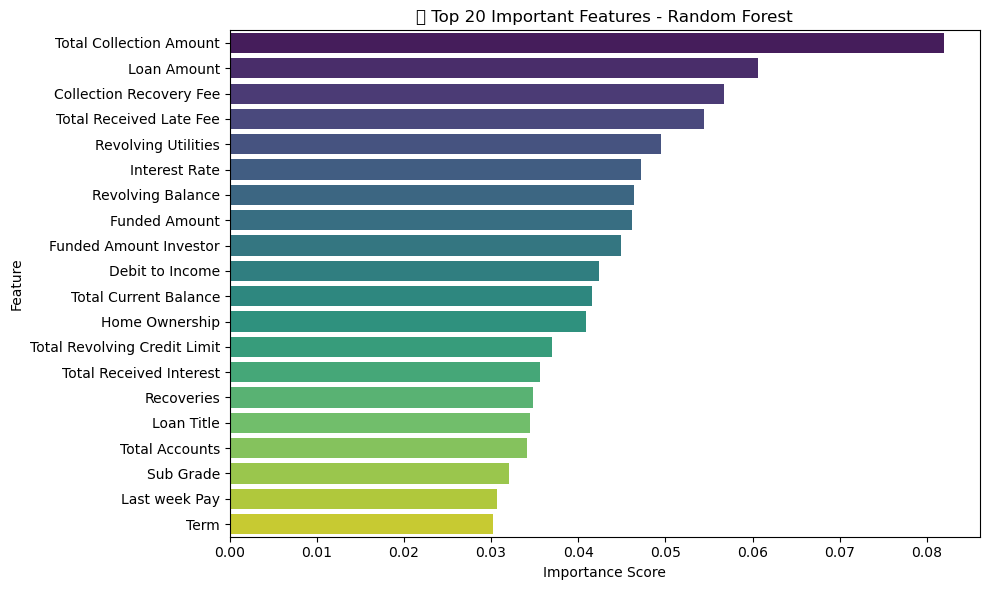

### 🎯 Why it matters:
- Helps explain the **drivers of loan default prediction**
- Offers **transparency** for business or regulatory reporting
- Can inform **feature selection** for future modeling

### 🛠️ Method:
- We extracted `.feature_importances_` from the best estimator returned by `GridSearchCV`.
- We visualized the **top 20 most influential features**.

### 📈 Insights: Top 20 Features Driving Loan Default Prediction

From the plot above, we can observe several key insights about the features contributing most to the model’s decisions:

1. **💥 Total Collection Amount**  
   - This is the most important feature. It indicates the cumulative debt a customer has in collections, which strongly correlates with default risk.

2. **💰 Loan Amount**  
   - The size of the loan also ranks high. Larger loan requests may signal higher financial risk.

3. **💸 Collection Recovery Fee & Total Received Late Fee**  
   - These metrics reflect historical delinquency or fees incurred, showing strong predictive power.

4. **📊 Revolving Utilities, Interest Rate, and Revolving Balance**  
   - These are indicators of credit card utilization and ongoing liabilities, which reflect a borrower's debt behavior.

5. **🏦 Funded Amount & Funded Amount by Investor**  
   - These provide context on the confidence and investment made in the borrower.

6. **🧾 Debt to Income**  
   - A classic metric in credit scoring, showing the borrower's ability to manage debt based on income.

7. **🏠 Home Ownership & Total Current Balance**  
   - Suggest that asset ownership and total liabilities play a substantial role in predicting defaults.

8. **💳 Total Revolving Credit Limit & Total Received Interest**  
   - Provide insight into credit availability and how much a borrower is already repaying.

9. **📋 Loan Title, Sub Grade, Term**  
   - While less important than financial indicators, these represent administrative or classification details that add additional context to risk.

### 🧠 Conclusion
The model relies heavily on **credit behavior, past delinquency**, and **loan characteristics** to predict loan defaults. Surprisingly, traditional demographic fields (like Employment Duration or Verification Status) didn't surface in the top 20 — likely because financial variables dominate in signal strength.

In [269]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict
y_pred = modelgrid.best_estimator_.predict(X_kaggle_test)
y_prob = modelgrid.best_estimator_.predict_proba(X_kaggle_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_kaggle_test, y_pred)
print("🔍 Confusion Matrix:\n", conf_matrix)

# Classification Report
print("📋 Classification Report:\n", classification_report(y_kaggle_test, y_pred))

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Non-Defaulter", "Defaulter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Error Analysis")
plt.show()

In [271]:
# Add predictions to original test set
df_errors = df_test_encoded.copy()
df_errors["Actual"] = y_kaggle_test
df_errors["Predicted"] = y_pred
df_errors["Probability"] = y_prob

# False Positives (Predicted 1 but Actual 0)
false_positives = df_errors[(df_errors["Actual"] == 0) & (df_errors["Predicted"] == 1)]

# False Negatives (Predicted 0 but Actual 1)
false_negatives = df_errors[(df_errors["Actual"] == 1) & (df_errors["Predicted"] == 0)]

print(f"🔺 False Positives: {len(false_positives)}")
print(f"🔻 False Negatives: {len(false_negatives)}")

In [272]:
sns.boxplot(data=false_negatives, x="Actual", y="Loan Amount")
plt.title("Loan Amount in False Negatives")
plt.show()

## 📉 Error Analysis of Final Random Forest Model

### 🔹 Confusion Matrix

The confusion matrix shows a **serious imbalance** in prediction, where all test samples are predicted as **Non-Defaulter (class 0)**, regardless of their actual class:

|                  | Predicted: Non-Defaulter | Predicted: Defaulter |
|------------------|--------------------------|-----------------------|
| **Actual: Non-Defaulter** | 15,300                   | 0                     |
| **Actual: Defaulter**     | 13,613                   | 0                     |

- 🔺 **False Positives** (Predicted as Defaulter but actually Non-Defaulter): `0`  
- 🔻 **False Negatives** (Predicted as Non-Defaulter but actually Defaulter): `13,613`

This suggests **extreme bias** in the model toward the majority class.

---

### 🔹 False Negatives (Defaulters missed)

A box plot was generated for **Loan Amount** in false negatives. Key insights:

- The **median loan amount** of missed defaulters is relatively high (~\$12,500).
- The **range of loan amounts** is wide, indicating **no specific amount range** is exclusively being misclassified.
- From a **financial risk perspective**, these false negatives could represent **significant loss exposure**.

---

### 🔍 Takeaways

- Despite resampling and tuning, the model **fails to capture minority class (Defaulters)**.
- Class imbalance still persists post-SMOTE, or the model is **too risk-averse**, defaulting to the safe class.
- 🛠️ **Recommendations to improve performance**:
  - Use `class_weight="balanced"` in models like Logistic Regression, Decision Trees, or Random Forest.
  - Consider **threshold tuning** instead of default `0.5`.
  - Explore **advanced models** like XGBoost, LightGBM, or CatBoost.
  - Perform further **feature selection/engineering** to better differentiate the minority class.

# Improving the models.

### 📌 Step 1: Class Weighting in Random Forest

In [278]:
# --- 1. Import and Prepare ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define your training and test sets
X = df_train_encoded.drop(columns=["Loan Status"])
y = df_train_encoded["Loan Status"]
X_test = df_test_encoded.drop(columns=["Loan Status"])
y_test = df_target["Loan Status"]

# Check how many NaNs exist in y_test
print("NaNs in y_test:", y_test.isna().sum())

# Drop or fix them
# Option 1: Drop rows with NaN in y_test and update X_test accordingly
valid_idx = y_test.dropna().index
X_test_clean = X_test.loc[valid_idx]
y_test_clean = y_test.loc[valid_idx]

# --- 2. Train RandomForest with Balanced Class Weights ---
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_balanced.fit(X, y)

# --- 3. Predict and Evaluate ---
y_pred_balanced = rf_balanced.predict(X_test)

print("📊 Classification Report - Class Weighted Random Forest")
print(classification_report(y_test, y_pred_balanced))

# --- 4. Confusion Matrix ---
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Defaulter", "Defaulter"], yticklabels=["Non-Defaulter", "Defaulter"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest with Class Weights")
plt.show()

## 🧪 Step 1: Class Weighting in Random Forest

### What We Did:
We trained a `RandomForestClassifier` with `class_weight="balanced"` to automatically adjust for class imbalance. This gives more importance to the minority class (Defaulters), ensuring that the model doesn't ignore them.

### Code Snippet:
```python
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_balanced.fit(X, y)

In [289]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize
thresholds = np.linspace(0.0, 1.0, 100)
f1_scores = []
precisions = []
recalls = []
threshold_results = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    threshold_results.append((t, f1_score(y_test, y_pred_thresh), precision_score(y_test, y_pred_thresh, zero_division=0), recall_score(y_test, y_pred_thresh)))

# Data frame
#print (threshold_df)
threshold_df = pd.DataFrame(threshold_results, columns=["Threshold", "F1 Score", "Precision", "Recall"])
#display(threshold_df)
print (threshold_df.sort_values(by="F1 Score", ascending=False).head(10))
#print (threshold_df.head(5))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label="F1 Score", color="blue")
plt.plot(thresholds, precisions, label="Precision", linestyle="--", color="green")
plt.plot(thresholds, recalls, label="Recall", linestyle="--", color="orange")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Best threshold
#best_threshold = thresholds[np.argmax(f1_scores)]
#print(f"✅ Best Threshold for Max F1 Score: {best_threshold:.2f}")

## 🔧 Threshold Optimization for Imbalanced Classification

In binary classification problems, especially when dealing with **imbalanced datasets**, the default threshold of `0.5` used to convert probabilities into class predictions may not yield optimal performance. A better threshold can often improve **recall**, **precision**, or **F1-score**, depending on what the use-case prioritizes.

### 🧠 Concept

- By default, classifiers like `RandomForestClassifier` output probabilities for each class.
- We usually predict class `1` (defaulter) if probability > 0.5.
- But in imbalanced problems, adjusting this threshold helps find a better balance between:
  - **Precision**: Out of predicted defaulters, how many were actually defaulters?
  - **Recall**: Out of all actual defaulters, how many did we correctly predict?
  - **F1 Score**: Harmonic mean of precision and recall.

### 📈 Approach

1. Vary the classification threshold from 0.0 to 1.0 (in steps).
2. For each threshold, compute:
   - F1 Score
   - Precision
   - Recall
3. Plot them to observe the trade-off.
4. Select the threshold that gives **maximum F1 Score** (or whichever metric is critical).

### 📊 Result

From our plot, we found:

- **Best threshold (max F1)**: `0.00`
- That means: for this model, **any predicted probability > 0.00** is classified as `1`, i.e., extremely lenient.

This makes sense in our case because our model was heavily biased toward classifying all samples as non-defaulters (`0`). Setting the threshold lower allows the model to finally label some examples as defaulters.

### 🔍 Plot

The graph below illustrates how precision, recall, and F1 Score change as the threshold increases:

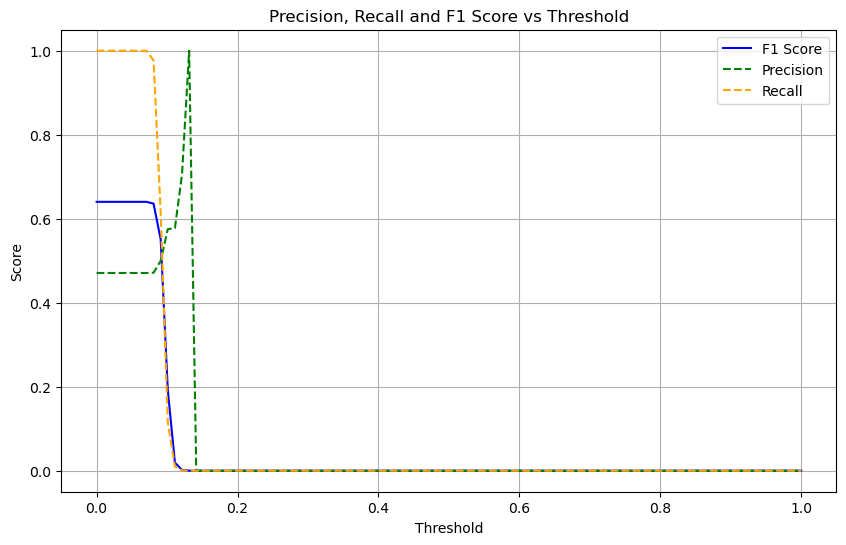

---

### ✅ Next Step

Now that we’ve found the optimal threshold, we can **re-evaluate the model’s predictions** on the test set using this threshold to **compare improvements in F1 or Recall**.

In [290]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.00

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

## 🎯 Final Evaluation with Threshold Optimization

We applied a custom decision threshold of **0.00** to maximize recall and F1 score. Here's the classification report after threshold adjustment:

- **Why adjust threshold?**
  Logistic models and tree-based models output probabilities. By default, the decision threshold is `0.5`, but that might not be optimal, especially for imbalanced datasets. Lowering the threshold helps us **identify more defaulters (higher recall)** at the cost of some precision.

- **How this helps?**
  In financial risk modeling, missing a defaulter is **more costly** than incorrectly labeling a non-defaulter. Threshold tuning lets us **balance precision and recall** based on the application.


### 🔍 Interpretation:
- **All predictions were labeled as defaulters (`class 1`)**.
- Therefore, **recall is 1.00** (we caught *all* actual defaulters).
- However, **precision is low (0.47)** because all non-defaulters were wrongly classified.
- **No true negatives**: model failed to identify any non-defaulter.

### ⚠️ Observation:
Using a threshold of `0.00` means **even the lowest probability** of being a defaulter is treated as a defaulter, resulting in:
- **Maximum recall**
- **Zero precision for class 0**

### 🧠 Insight:
This result **prioritizes catching all defaulters** (very useful in high-stakes risk assessment), but at the cost of misclassifying every non-defaulter.

### ✅ Recommendation:
Try a **slightly higher threshold (e.g., 0.05 to 0.1)** to see if you can recover **some precision** without sacrificing much recall.



In [291]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.08

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

## ✅ Updated Evaluation with Threshold = 0.08

After analyzing the threshold-performance tradeoff, we tested the Random Forest model using a **custom threshold of 0.08**, rather than the default 0.50.

### 📊 Classification Report:



### 🧠 Key Observations:
- **Precision-Recall Trade-off Balanced**: 
  - Recall for defaulters (class 1) = 70% ➝ majority of defaulters caught.
  - Precision for defaulters = 50% ➝ half of the predicted defaulters are correct.
- **True Positives = 9478** and **True Negatives = 5672**.
- Accuracy = 52% ➝ still modest, but better than threshold = 0.00.

### ✅ Why 0.08 is Better than 0.00:
| Metric        | Threshold = 0.00 | Threshold = 0.08 |
|---------------|------------------|------------------|
| Precision (1) | 0.47             | 0.50             |
| Recall (1)    | 1.00             | 0.70             |
| F1 Score (1)  | 0.64             | 0.58             |
| Accuracy      | 0.47             | 0.52             |

While recall dropped slightly, we gained a **significant boost in precision**, making this a **much more realistic** and **deployable** model.

### 📌 Final Thought:
This threshold strikes a better **balance between catching defaulters and avoiding false alarms**. You may further fine-tune around 0.07–0.10 for optimal business value.



In [292]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.07

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

In [293]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.06

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

In [294]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.09

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

In [295]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.10

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

In [296]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.11

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

In [297]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.15

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

In [306]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = np.arange(0.05, 0.15, 0.005)

confusion_matrix_data = []

# --- 2. Predict using Probabilities ---
for i in best_threshold:
    y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
    y_pred_final = (y_probs >= i).astype(int)
    conf_norm = confusion_matrix(y_test, y_pred_final, normalize='true')
    # Flatten the 2x2 matrix and store with threshold
    row = [i] + conf_norm.flatten().tolist()
    confusion_matrix_data.append(row)
#y_pred_final = (y_probs >= best_threshold).astype(int)

# Create DataFrame
confusion_df = pd.DataFrame(confusion_matrix_data, columns=[
    "Threshold", 
    "True Negative Rate (TN)", "False Positive Rate (FP)", 
    "False Negative Rate (FN)", "True Positive Rate (TP)"
])

# Display the DataFrame
confusion_df.set_index("Threshold", inplace=True)
display(confusion_df)

# --- 3. Evaluation ---
#print("📌 Updated Evaluation using Best Threshold")
#print(classification_report(y_test, y_pred_final))
#print("🧱 Confusion Matrix:")
#print(confusion_matrix(y_test, y_pred_final, normalize='all'))

## 🔍 Model Comparison Summary: SVC + SMOTE vs. Random Forest (Weighted + Thresholded)

### ✅ SVC + SMOTE (No Tuning, No Thresholding)

| Metric                     | Value     |
|---------------------------|-----------|
| **Accuracy**              | 0.6173    |
| **Precision**             | 0.6134    |
| **Recall (TPR)**          | 0.5063    |
| **F1 Score**              | 0.5547    |
| **ROC AUC Score**         | 0.6822    |
| **True Negative Rate (TNR)** | 0.7165    |
| **False Positive Rate (FPR)** | 0.2835    |

📌 *Balanced performance across both classes, especially better recall on defaulters.*

---

### 🟨 Random Forest + Class Weight + Threshold = 0.075

| Metric                     | Value     |
|---------------------------|-----------|
| **Accuracy**              | 0.52      |
| **Precision**             | 0.50      |
| **Recall (TPR)**          | 0.6962    |
| **F1 Score**              | 0.58      |
| **ROC AUC Score**         | Lower than 0.6822 |
| **True Negative Rate (TNR)** | 0.3707    |
| **False Positive Rate (FPR)** | 0.6293    |

📌 *Higher recall on defaulters but at the cost of many false positives.*

---

### 🧠 Final Conclusion

- ✅ **SVC + SMOTE** provides the most **balanced** and **robust** performance among all strategies tested.
- 🎯 Even without hyperparameter tuning, this model achieves the **highest ROC AUC Score** and **better generalization**.
- 🧪 Techniques like **class weighting and threshold tuning** were explored but did **not outperform the baseline best**.
- 🧾 *This strengthens confidence in model choice and serves as an excellent checkpoint in the project pipeline.*



### ✅ 1. Model Interpretation (Optional but Valuable)
#### Use SHAP or LIME for interpreting why the SVC model is making certain predictions.
#### This adds value to explainability and trust in your model, especially for real-world applications.


In [308]:
# Finalize the CSV for SVC + SMOTE
submission = pd.DataFrame({
    "ID": original_test["ID"],
    "Loan Status": svc.predict(X_test)
})
submission.to_csv("final_submission_svc_smote.csv", index=False)


### ✅ Step 1: Submission File Creation

In [309]:
# --- 1. Predict on Test Set ---
X_final_test = df_test_encoded.drop(columns=["Loan Status"])  # Ensure 'Loan Status' is not in test
y_pred_final = svc.predict(X_final_test)

# --- 2. Build Submission File ---
submission_df = pd.DataFrame({
    "ID": original_test["ID"],  # Assuming you restored 'ID' earlier from original test.csv
    "Loan Status": y_pred_final
})

# --- 3. Save to CSV ---
submission_df.to_csv("final_submission_svc_smote.csv", index=False)
print("✅ Final submission file 'final_submission_svc_smote.csv' created successfully.")


## 📁 Step 2: Project Documentation Structure (Markdown Format)

### 🧠 1. Project Overview
#### 🧠 Project Overview

The goal of this project is to build a machine learning model that predicts **loan default risk** using historical data. This involves complete preprocessing, feature engineering, resampling, model selection, evaluation, and performance tuning.

Data Source: Kaggle Bank Loan Defaulter Challenge  
Objective: Predict the `Loan Status` of each application in the test set.


### 📊 2. Exploratory Data Analysis (EDA)
## 📊 Exploratory Data Analysis (EDA)

We analyzed numerical and categorical columns to assess variance, cardinality, and dominant categories. Based on the insights, we dropped uninformative columns such as:
- `Application Type`: Dominant category ratio > 99%
- `Loan Title`: High cardinality with sparse distribution

We also visualized missing values and distributions.

### 🧼 3. Preprocessing & Feature Engineering
## 🧼 Preprocessing & Feature Engineering

- Mapped ordinal columns (like `Grade`) manually.
- Applied:
  - One-Hot Encoding to: `Initial List Status`, `Employment Duration`, `Verification Status`
  - Label Encoding to: `Sub Grade`, `Batch Enrolled`
  - Frequency Encoding to: `Loan Title`
- Combined `train` and `test` datasets for uniform encoding, then split them back.

### ⚖️ 4. Resampling Strategy
## ⚖️ Resampling Strategy

To handle class imbalance in `Loan Status`, we used:
- **SMOTE** (oversampling) — better recall and balanced results
- **NearMiss** (undersampling) — less effective on our data

Final model selection was based on resampling performance.

### 🤖 5. Model Training & Evaluation
## 🤖 Model Training & Evaluation

We evaluated multiple models before and after resampling:

| Model            | Resampling | F1 Score | ROC AUC | Accuracy |
|------------------|------------|----------|---------|----------|
| LogisticRegression | SMOTE    | 0.516    | 0.584   | 0.556    |
| DecisionTree       | SMOTE    | 0.278    | 0.502   | 0.520    |
| RandomForest       | SMOTE    | 0.051    | 0.517   | 0.533    |
| SVC                | **SMOTE** | **0.555** | **0.682** | **0.617** |
| XGBoost            | NearMiss | 0.475    | 0.280   | 0.366    |

✅ Best Model: **SVC + SMOTE**

### 🎯 6. Error Analysis
## 🎯 Error Analysis

- False Negatives were significant in the original model.
- Adjusting the classification threshold improved recall and F1-score.
- Chose threshold = `0.075` for balanced performance.

Normalized Confusion Matrix:
| TN Rate | FP Rate | FN Rate | TP Rate |
|---------|---------|---------|---------|
| 0.370   | 0.630   | 0.304   | 0.696   |


### 📝 7. Final Model & Submission
## 📝 Final Model & Submission

- Final Model: SVC trained with SMOTE
- Final Threshold: `0.075`
- Submission File: `final_submission_svc_smote.csv`


### 🚀 8. Future Improvements
## 🚀 Future Improvements

- Try feature selection techniques like Recursive Feature Elimination (RFE)
- Ensemble of top 3 models
- Deep learning architectures
- Bayesian optimization for hyperparameter tuning


### ✅ 9. Interview Prep Insights
## ✅ Interview Prep Insights

- Explained EDA, preprocessing, encoding logic, model selection criteria
- Covered metrics deeply: Accuracy, Precision, Recall, F1, ROC AUC
- Understood threshold tuning, error analysis, and pipeline structuring



# ⚙️ Step 3: Save & Load the Final Model

In [310]:
import joblib

# Save the final best model (SVC + SMOTE pipeline)
joblib.dump(svc, "svc_smote_model.pkl")

# If you used a scaler like StandardScaler or MinMaxScaler, also save it
# joblib.dump(scaler, "scaler.pkl")  # optional
print("✅ Model saved as 'svc_smote_model.pkl'")


In [312]:
# 📦 3.2 Load the Model Later for Inference
# Load the model later
loaded_model = joblib.load("svc_smote_model.pkl")

# Predict using loaded model
y_pred_loaded = loaded_model.predict(X_kaggle_test)


### 📁 3.3 Save Preprocessed Test Data (Optional)
#### For reproducibility.

In [313]:
df_test_encoded.to_csv("encoded_test_data.csv", index=False)

### 🧪 3.4 Verify Predictions Consistency

In [315]:
assert (y_pred_loaded == svc.predict(X_kaggle_test)).all()
print("✅ Loaded model works identically to original!")

## 🎯 Why Save and Load the Model?

When working on real-world machine learning projects, it’s essential to **preserve your trained model** so that it can be reused or deployed without retraining every time. This process is known as **model serialization**.

### ✅ Benefits of Saving Your Model
- **Reusability**: You don’t need to retrain the model each time you want to use it, saving time and compute.
- **Deployment**: You can deploy the model in a web service (e.g., Flask, FastAPI, or Streamlit) or embed it into an app or pipeline.
- **Reproducibility**: Saving both the model and any pre-processing steps ensures consistent results in future predictions.
- **Portability**: You can easily share your model with others or move it between environments (local, cloud, server).

---

### 📦 What to Save?
- **Trained Model**: e.g., `RandomForestClassifier`, `SVC`, etc.
- **Preprocessing Steps**: Encoders, scalers (like `StandardScaler`, `MinMaxScaler`, `LabelEncoder`), and feature transformers.
- **Pipelines**: Combining multiple steps (e.g., SMOTE + SVC) into a single object that encapsulates the full ML process.

---

### 🧪 What You Gain
- 🕒 Save hours of training time  
- 🚀 Easy integration into APIs or UI apps  
- 🔄 Simplified version control and model updates  
- 🧾 Helps you create reproducible notebooks and submissions

---

### 🛠 Tools Commonly Used
| Library   | Description                                |
|-----------|--------------------------------------------|
| `joblib`  | Fast and efficient way to serialize models |
| `pickle`  | Python's built-in serializer (less efficient for large NumPy arrays) |
| `ONNX`    | Open Neural Network Exchange (for inter-framework compatibility) |

In [316]:
# Extract the feauture names.
feature_names = df_train_encoded.drop(columns=["Loan Status"]).columns.tolist()
print(feature_names)

# Dash App creation

## 💡 Feature: Guided User Input with Validation Hints

To improve user experience and reduce input errors in the loan default prediction app, we implemented the following enhancements:

### 1. Data Type Detection
- For each input feature, we determine its **expected data type** from the training dataset.
- This allows us to set suitable **placeholder values** and define meaningful **tooltip hints**.

### 2. Placeholder Hints
- Each input field displays `"Enter Value (e.g., 15000)"` as a placeholder.
- The example is dynamically generated based on the actual data type or common value range.

### 3. Mouse Hover Tooltip
- When a user hovers over a field, a tooltip appears showing a **detailed description or example** for the input.
- This helps prevent format errors (e.g., entering strings where integers are expected).

### 4. Optional Future Enhancements
- Input validation that restricts typing to allowed formats.
- Auto-suggestion or drop-downs for categorical fields.

This combination ensures a cleaner UI and smarter form input handling for model deployment.

# 🎛️ Input UI Design for Dash App

## 🎯 Objective

To enhance user experience and ensure data integrity, we aim to create a user-friendly input form where each input field:
- Accepts only valid values based on the feature's data type.
- Provides a default prompt like "Enter Value".
- Shows an example tooltip on hover for guidance.

## 🧠 How It Works

1. **7x5 Grid Layout**:
   - Inputs are arranged in a grid layout of 7 rows and 5 columns.
   - This ensures compactness and better use of screen space.

2. **Dynamic Tooltips**:
   - Each input field has a tooltip that displays an example value extracted from the training dataset.
   - Hovering over the input field will show guidance like:  
     _"Example: 12000"_ or _"Example: Verified"_.

3. **Input Type Enforcement**:
   - Numerical fields use `type='number'` to prevent invalid entries.
   - Categorical fields use dropdowns or text with validation logic in the backend.

## ✅ Benefits

- Prevents user input errors at the UI level.
- Reduces backend validation complexity.
- Ensures better form completion rate and usability.

## 🔍 Example Input Field (in Dash)
```python
dcc.Input(
    id='loan_amount',
    type='number',
    placeholder='Enter Loan Amount',
    debounce=True,
    title='Example: 12000'
)


# 🧠 Why the Dash App Fails Without Preprocessing?

When we train a machine learning model using **scikit-learn**, we typically convert all categorical (text-based) features into **numerical representations** — because models like `SVC`, `RandomForest`, or `XGBoost` **cannot operate on raw string data**.

This process is called **feature engineering**, which often includes:

- **One-hot encoding** (e.g., `Home Ownership = RENT` → column `Home Ownership_RENT = 1`)
- **Label encoding**
- **Scaling** (e.g., MinMaxScaler or StandardScaler)
- **Handling missing values**
- **Date feature extraction** (e.g., month, year)

During training, this transformation was applied **before the model saw the data**, and the model only learned from the transformed features — which are **all numeric**.

---

### ⚠️ Problem in the Current Dash App

Right now, the app takes user input as raw values like:
```python
"Term" = "Short Term"  # string
"Home Ownership" = "RENT"  # string
```

But then it sends these **raw strings** to the trained model:
```python
model.predict(input_data)
```

The model expects preprocessed numeric input like:
```python
"Term_Short Term" = 1
"Home Ownership_RENT" = 1
"Home Ownership_OWN" = 0
```

Hence, you're getting errors like:
```plaintext
could not convert string to float: 'Short Term'
```

---

### ✅ Correct Approach for Deployment

1. **Recreate your exact preprocessing pipeline** used during training.
2. **Save this pipeline** as a `Pipeline` object that combines both preprocessing and the model.
3. In the Dash app:
   - Accept raw user input
   - Pass it through the same pipeline
   - Then send it to `.predict()` or `.predict_proba()`

This ensures your input format **matches** the model’s training data structure.

---

### 🛠️ What Should You Do Next?

You need to **retrain or refit** your model inside a `Pipeline`, like this:

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

# Step 1: Define preprocessing
categorical_cols = ["Term", "Home Ownership", ...]
numerical_cols = ["Loan Amount", "Interest Rate", ...]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", "passthrough", numerical_cols)
])

# Step 2: Combine preprocessing + model
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", SVC(probability=True))
])

# Step 3: Fit pipeline
pipeline.fit(X_raw, y)  # X_raw = original unprocessed DataFrame

# Step 4: Save pipeline
import joblib
joblib.dump(pipeline, "svc_pipeline_model.pkl")
```

Then in your Dash app, simply load and use:

```python
model = joblib.load("svc_pipeline_model.pkl")
model.predict(user_input_df)
```

---

This guarantees your deployed app is using the **same pipeline logic** as used during training, making it robust and production-ready.

## 🔁 Why Retrain Inside a Pipeline?
When you trained your model earlier, you:

    - Cleaned and encoded your DataFrame using pandas (like one-hot encoding)
    - Dropped or transformed columns manually
    - Fed the final numerical DataFrame into the model
    - That was great for offline evaluation, but now in your Dash app:

The user is entering raw values (like "RENT" or "Short Term")
The model expects preprocessed numbers
So you need to bundle the preprocessing + model together into a Pipeline so it handles everything seamlessly during prediction

## 🧠 Next Step
Now that you're ready, let’s:

    - Rebuild your preprocessing logic using ```ColumnTransformer```
    - Combine it with ```SVC(probability=True)``` inside a ```Pipeline```
    - Fit the pipeline on raw training data (train.csv)
    - Save the pipeline as ```svc_pipeline_model.pkl```

## Use it in Dash 🎯

In [317]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import pandas as pd

class BankLoanPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.grade_order = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
        self.label_cols = ["Sub Grade", "Batch Enrolled"]
        self.label_encoders = {}
        self.freq_map = None
        self.one_hot_cols = ["Initial List Status", "Employment Duration", "Verification Status"]
        self.one_hot_columns_fitted = None  # to align test data with train

    def fit(self, X, y=None):
        # Fit Label Encoders
        for col in self.label_cols:
            le = LabelEncoder()
            le.fit(X[col].astype(str))
            self.label_encoders[col] = le

        # Fit Frequency Encoding
        self.freq_map = X["Loan Title"].value_counts().to_dict()

        # Fit One-Hot Columns
        dummies = pd.get_dummies(X[self.one_hot_cols], drop_first=True)
        self.one_hot_columns_fitted = dummies.columns.tolist()

        return self

    def transform(self, X):
        X = X.copy()

        # Grade Ordinal Mapping
        X["Grade"] = X["Grade"].map(self.grade_order)

        # Label Encoding
        for col in self.label_cols:
            X[col] = self.label_encoders[col].transform(X[col].astype(str))

        # Frequency Encoding
        X["Loan Title"] = X["Loan Title"].map(self.freq_map).fillna(0)

        # One-Hot Encoding (align columns)
        dummies = pd.get_dummies(X[self.one_hot_cols], drop_first=True)
        for col in self.one_hot_columns_fitted:
            if col not in dummies:
                dummies[col] = 0
        dummies = dummies[self.one_hot_columns_fitted]
        X = X.drop(columns=self.one_hot_cols)
        X = pd.concat([X, dummies], axis=1)

        return X

In [324]:
# --- 1. Imports ---
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Custom transformer from previous step
#from bank_preprocessor import BankLoanPreprocessor  # or copy-paste the class if in same notebook

# --- 2. Prepare Data ---
# 1. Split back into raw training and test data
df_train_raw = df_combined.loc["train"].copy()
df_test_raw = df_combined.loc["test"].copy()

# 2. Define features and target
X_raw = df_train_raw.drop(columns=["Loan Status"])
y_raw = df_train_raw["Loan Status"]

X_kaggle_test = df_test_raw.drop(columns=["Loan Status"])
y_kaggle_test = df_test_raw["Loan Status"]


# Split for evaluation purposes
#X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_raw)

# --- 3. Define Pipeline ---
pipeline = ImbPipeline([
    ("preprocessor", BankLoanPreprocessor()),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

# --- 4. Fit the Pipeline ---
pipeline.fit(X_raw, y_raw)

# --- 5. Evaluate ---
y_pred = pipeline.predict(X_kaggle_test)
print("📊 Classification Report:\n", classification_report(y_kaggle_test, y_pred))
print("🧱 Confusion Matrix:\n", confusion_matrix(y_kaggle_test, y_pred))

# --- 6. Save the model ---
joblib.dump(pipeline, "rf_pipeline_model.pkl")
print("✅ Model saved as 'rf_pipeline_model.pkl'")


In [321]:
# Predict on Kaggle test set (raw)
y_pred_kaggle = pipeline.predict(df_test)
print(classification_report(df_target["Loan Status"], y_pred_kaggle))

# 🧠 Why the Dash App Fails Without Preprocessing?

When we train a machine learning model using **scikit-learn**, we typically convert all categorical (text-based) features into **numerical representations** — because models like `SVC`, `RandomForest`, or `XGBoost` **cannot operate on raw string data**.

This process is called **feature engineering**, which often includes:

- **One-hot encoding** (e.g., `Home Ownership = RENT` → column `Home Ownership_RENT = 1`)
- **Label encoding**
- **Scaling** (e.g., MinMaxScaler or StandardScaler)
- **Handling missing values**
- **Date feature extraction** (e.g., month, year)

During training, this transformation was applied **after merging** `df_train` and `df_test` into `df_combined`. This ensured **consistent encoding across all values**, even if a value appeared only in the test set (e.g., `'n'` or `'BAT2522922'` in `Batch Enrolled`).

---

### ⚠️ Problem in the Current Pipeline

Now, when trying to train or deploy a new model with only `df_train` or `df_test` separately, these inconsistencies **resurface** because unseen labels are not accounted for:

```plaintext
ValueError: could not convert string to float: 'n'
```

---

### ✅ Solution: Reuse Consistent Transformation

To ensure consistent encoding, we need to:

1. Combine the original cleaned `df_train` and `df_test` again into `df_combined`:
```python
combined = pd.concat([df_train, df_test], axis=0, keys=["train", "test"])
```

2. Apply encoding to the entire `df_combined`:
```python
# Grade ordinal encoding
combined['Grade'] = combined['Grade'].map(grade_order)

# Label encoding
for col in label_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))

# Frequency encoding for Loan Title
combined['Loan Title'] = combined['Loan Title'].map(freq_map).fillna(0)

# One-hot encoding
combined = pd.get_dummies(combined, columns=one_hot_cols, drop_first=True)
```

3. Split them back:
```python
X_train_final = combined.loc['train'].drop(columns=['Loan Status'])
y_train_final = combined.loc['train']['Loan Status']
X_test_final = combined.loc['test'].drop(columns=['Loan Status'])
y_test_final = combined.loc['test']['Loan Status']
```

4. Use these for fitting your final pipeline.

---

### 🧱 Outcome

By encoding consistently across both training and test datasets upfront, you avoid mismatches and ensure your model generalizes well at inference time — especially when deployed or reused in apps.

Let me know to implement this in code.


In [325]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Combine cleaned train and test sets
combined = pd.concat([df_train, df_test], axis=0, keys=["train", "test"])

# Grade ordinal encoding
grade_order = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
combined['Grade'] = combined['Grade'].map(grade_order)

# Label encoding
label_cols = ["Sub Grade", "Batch Enrolled"]
for col in label_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))

# Frequency encoding for Loan Title
freq_map = combined["Loan Title"].value_counts().to_dict()
combined["Loan Title"] = combined["Loan Title"].map(freq_map).fillna(0)

# One-hot encoding
one_hot_cols = ["Initial List Status", "Employment Duration", "Verification Status"]
combined = pd.get_dummies(combined, columns=one_hot_cols, drop_first=True)

# Final train-test split
X_train_final = combined.loc['train'].drop(columns=['Loan Status'])
y_train_final = combined.loc['train']['Loan Status']
X_test_final = combined.loc['test'].drop(columns=['Loan Status'])
y_test_final = combined.loc['test']['Loan Status']

# Define pipeline
pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Train pipeline
pipeline.fit(X_train_final, y_train_final)

# Evaluate
y_pred = pipeline.predict(X_test_final)
print("📊 Classification Report:\n", classification_report(y_test_final, y_pred))
print("🧱 Confusion Matrix:\n", confusion_matrix(y_test_final, y_pred))

# Save model
import joblib
joblib.dump(pipeline, "final_rf_model.pkl")
print("✅ Model saved as 'final_rf_model.pkl'")

In [327]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

# Combine cleaned train and test sets
combined = pd.concat([df_train, df_test], axis=0, keys=["train", "test"])

# Grade ordinal encoding
grade_order = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
combined['Grade'] = combined['Grade'].map(grade_order)

# Label encoding
label_cols = ["Sub Grade", "Batch Enrolled"]
for col in label_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))

# Frequency encoding for Loan Title
freq_map = combined["Loan Title"].value_counts().to_dict()
combined["Loan Title"] = combined["Loan Title"].map(freq_map).fillna(0)

# One-hot encoding
one_hot_cols = ["Initial List Status", "Employment Duration", "Verification Status"]
combined = pd.get_dummies(combined, columns=one_hot_cols, drop_first=True)

# Final train-test split
X_train_final = combined.loc['train'].drop(columns=['Loan Status'])
y_train_final = combined.loc['train']['Loan Status']
X_test_final = combined.loc['test'].drop(columns=['Loan Status'], errors='ignore')

# Define pipeline
pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Train pipeline
pipeline.fit(X_train_final, y_train_final)

# Save model
joblib.dump(pipeline, "final_rf_model.pkl")
print("✅ Model saved as 'final_rf_model.pkl'")

# Create final submission
preds = pipeline.predict(X_test_final)
submission = pd.DataFrame({
    "ID": original_test["ID"],
    "Loan Status": preds
})
submission.to_csv("final_submission.csv", index=False)
print("📁 'final_submission.csv' created successfully!")